# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# from sklearn.feature_selection import RFE
# from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
# from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')
# % matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Exploratory Analysis

## Read the data

Before doing analysis, it is important to read the data. Understand how data stored in the dataframe, if there are missing values and so on.

### Transcript

In [3]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [4]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [5]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [6]:
714/24

29.75

The transcript contains about 1 month transaction data.

In [7]:
#check value counts
def check_value_counts(df, col):
    '''
    Check counts of the col values
    
    Args:
        df (DataFrame): The DataFrame 
        col (str): The col needs to get counts
    
    Returns:
        vc(Series): The Series of col with number of counts
    '''
    vc = df[col].value_counts() 
    return vc

In [8]:
check_value_counts(transcript, "event")

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [9]:
check_value_counts(transcript,"person")

94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
5e60c6aa3b834e44b822ea43a3efea26    48
79d9d4f86aca4bed9290350fb43817c2    48
d0a80415b84c4df4908b8403b19765e3    48
                                    ..
cae5e211053f4121a389a7da4d631f7f     2
fccc9279ba56411f80ffe8ce7e0935cd     2
22617705eec442e0b7b43e5c5f56fb17     2
912b9f623b9e4b4eb99b6dc919f09a93     2
da7a7c0dcfcb41a8acc7864a53cf60fb     1
Name: person, Length: 17000, dtype: int64

Some customers shopped about 2 times a day while some customers shop about a few times within the 30 days. The shopping behaviors are vary.

In [10]:
check_value_counts(transcript,"time")

408    17030
576    17015
504    16822
336    16302
168    16150
       ...  
318      940
330      938
156      914
162      910
150      894
Name: time, Length: 120, dtype: int64

The 17th day had the most daily transactions

In [11]:
transcript.groupby("event").sample(n=3, random_state=123)

,person,event,value,time
279096,f2e49f5002c540eb92ca320fea990319,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,612
275967,815e75930aed488cb61d56afb4627457,offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,606
278841,31e915c24163436790b97c1d45b545f6,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,612
251717,153f7ce19d8f4c8294fdc8d758c880c7,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},576
6233,3e9e889fc54c412fb7d032421f4890c7,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
213658,f5d31009d87f411091be6b7d008564cf,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},504
262507,3f9da79caafe40478a8a661e53b7299b,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},582
93436,e23f93dde99743dbbfad6ca2674e4b92,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},240
25381,7236a35b4970427cb85791371e40d96a,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},30
23283,2704e553ed8143569367e34c7c620f5f,transaction,{'amount': 7.07},24


The offer related event like offer received, offer viewed and offer completed contains offer ids. While the transaction event only contains the shopping amount. Based on this dataset, it is hard to link which transactions are offer related transactions and which are not.

In [12]:
#check null values
def check_null_values(df):
    '''
    Check nulls in the dataframe
    
    Args:
        df(DataFrame): The DataFrame needs to check 
    
    Returns:
        nv(Series): The Series of number of nulls
    '''
    nv = df.isnull().sum()
    return nv

In [13]:
check_null_values(transcript)

person    0
event     0
value     0
time      0
dtype: int64

The transcript dataframe doesn't contain missing values

### Portfolio

In [14]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [15]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [16]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


Reward and difficulty are more like categorical variables instead of ints. Need to convert the data type of these two variables.

In [17]:
check_value_counts(portfolio,"reward")

5     3
10    2
2     2
0     2
3     1
Name: reward, dtype: int64

In [18]:
check_value_counts(portfolio,"difficulty")

10    4
5     2
0     2
7     1
20    1
Name: difficulty, dtype: int64

In [19]:
check_value_counts(portfolio, "offer_type")

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

In [20]:
check_null_values(portfolio)

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

Portfolio dataframe contains no missing values.

### Profile

In [21]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [22]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [23]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


The became_member_on is date data type. Need to do a conversion.

In [24]:
check_value_counts(profile, "age")

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

There are many outliers in the age columns like age 118, age 101. Not sure about age 101 but age 118 are more like a placeholder. Need to replace it with null values and fulfill them.

In [25]:
check_value_counts(profile,"gender")

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [26]:
check_value_counts(profile,"became_member_on")

20171207    43
20170819    42
20171007    40
20171113    39
20170928    38
            ..
20150519     1
20131121     1
20131201     1
20150102     1
20140921     1
Name: became_member_on, Length: 1716, dtype: int64

In [27]:
check_value_counts(profile,"income")

73000.0     314
72000.0     297
71000.0     294
57000.0     288
74000.0     282
           ... 
116000.0     46
107000.0     45
112000.0     45
117000.0     32
120000.0     13
Name: income, Length: 91, dtype: int64

In [28]:
check_null_values(profile)

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

There are some missing values and messy data in the profile dataframe. Need to clean these data before doing the analysis

## Data Cleaning

### Transcript

In [29]:
transcript.rename(columns = {'person':'customer_id'}, inplace=True)

In [30]:
transcript.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


Need to break the value columns and get the offer ids and transaction amounts for further analysis.

In [31]:
#get unique keys in the value column
keys = set()
for i in range(transcript.shape[0]):  
    k = list(transcript['value'].values[i].keys())
    n_k = len(k)
    for j in range(n_k):
        keys.add(k[j])
keys

{'amount', 'offer id', 'offer_id', 'reward'}

In [32]:
keys = list(keys)

In [33]:
def get_key_values(df, col):
    '''
    Get key and value pairs from the target column
    
    Args:
        df(DataFrame): The DataFrame will processing
        col(dict): the columns contain the dict to get the key and value
    
    Returns:
        k(str or int): all the keys in the column
        v(str or int): all the values in the column
    '''
    k = df[col].values[0].keys()
    v = df[col].values[0].values()
    return k, v

In [34]:
for key in keys:
    transcript[key] = transcript["value"].apply(lambda k: k[key] if key in k else 0)
transcript.head()

,customer_id,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,0.0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,0


In [35]:
transcript["portfolio_id"] = transcript.apply(lambda x: x["offer id"] if x["offer id"] != 0 else x["offer_id"], axis = 1)

In [36]:
transcript.drop(["offer id", "offer_id", "value"], axis = 1, inplace=True)

In [37]:
transcript.head()

,customer_id,event,time,amount,reward,portfolio_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [38]:
transcript["event"].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [39]:
transcript.loc[transcript["portfolio_id"]==0, "amount"].describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

## Portfolio

In [40]:
portfolio.rename(columns ={'id':'portfolio_id'}, inplace=True)

In [41]:
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [42]:
channels_max = portfolio['channels'].max()
channels_min = portfolio['channels'].min()
channels_max, channels_min

(['web', 'email', 'mobile', 'social'], ['email', 'mobile', 'social'])

In [43]:
for channel in channels_max:
    portfolio['channel_' + channel] = portfolio.apply(lambda x: 1 if channel in x['channels'] else 0, axis = 1)

In [44]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,portfolio_id,channel_web,channel_email,channel_mobile,channel_social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


In [45]:
portfolio.drop(['channels'], axis = 1, inplace=True)

In [46]:
portfolio["offer_name"] = "offer_"+portfolio.index.astype(str)

In [47]:
portfolio.head()

,reward,difficulty,duration,offer_type,portfolio_id,channel_web,channel_email,channel_mobile,channel_social,offer_name
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,offer_0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,offer_1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,offer_2
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,offer_3
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,offer_4


## Profile

In [48]:
profile.rename(columns={'id':'customer_id'}, inplace=True)

In [49]:
profile["customer_name"] = "customer_"+profile.index.astype(str)

In [50]:
profile['became_member_on'] = profile.apply(lambda x: pd.to_datetime(str(x['became_member_on']), format='%Y%m%d'), axis = 1)

In [51]:
profile['days_since_member'] = (pd.to_datetime("today") - profile['became_member_on']).dt.days

In [52]:
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

Because there are many place holders (age 118) in the dataset. Need to convert and clean them.

In [53]:
# profile['age'].replace([118], np.nan, inplace=True)

In [54]:
# profile.loc[~profile["age"].isnull(), "age"].describe()

Text(0.5,1,'Age Distribution')

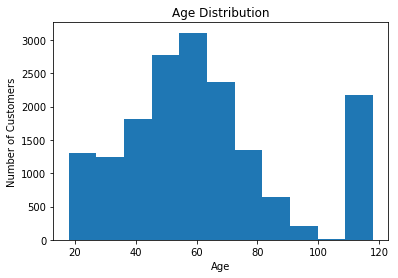

In [55]:
# plt.hist(profile.loc[~profile["age"].isnull(), "age"], bins = 20)
plt.hist(profile.loc[:, "age"], bins = 11)
plt.xlabel("Age")
plt.ylabel("Number of Customers")
plt.title("Age Distribution")

Need to fill the missing values in the age column and imputate a random number between 25 percentile - 75 percentile.

In [56]:
# def cus_fill_na(df, col):
#     """
#     Fulfill null values by using random number between 25 percentile and 75 percentile
    
#     Args:
#         df (DataFrame): The DataFrame to fulfill nulls
#         col (int): The int col to fulfill nulls
    
#     Returns:
#         df[col](Series): The Series of col with all nulls fulfilled
#     """
#     upper_lim = df.loc[~df[col].isnull(), col].quantile(.75)
#     lower_lim = df.loc[~df[col].isnull(), col].quantile(.25)
#     df[col] = df[col].fillna(np.random.randint(lower_lim, upper_lim, 1)[0])
    
#     return df[col]

In [57]:
# profile['age'] = cus_fill_na(profile, "age")

In [58]:
# profile['age'].describe()

In [59]:
# plt.hist(profile["age"], bins = 20)
# plt.xlabel("Age")
# plt.ylabel("Number of Customers")

Fill the missing values in the income by the same imputation logic as the one of age.

In [60]:
profile["income"].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

Text(0,0.5,'Number of Customers')

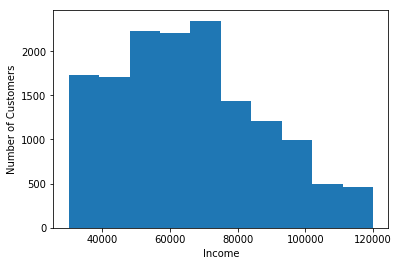

In [61]:
plt.hist(profile.loc[~profile["income"].isnull(), "income"], bins = 10)
plt.xlabel("Income")
plt.ylabel("Number of Customers")

In [62]:
income_median = np.median(profile.loc[~profile["income"].isnull(), "income"])

In [63]:
profile["income"].fillna(income_median, inplace=True)

In [64]:
profile["income"].describe()

count     17000.000000
mean      65225.235294
std       20174.747749
min       30000.000000
25%       51000.000000
50%       64000.000000
75%       76000.000000
max      120000.000000
Name: income, dtype: float64

Text(0,0.5,'Number of Customers')

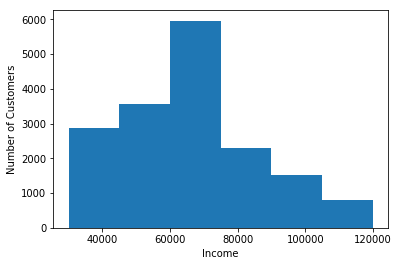

In [65]:
plt.hist(profile['income'], bins = 6)
plt.xlabel("Income")
plt.ylabel("Number of Customers")

# Group Transcript Data

Because the transactions don't associate with an offer id. It is hard to know what transactions are realted with offer or related with what offer. To get better analysis for what customers interested in offers and what offers. It is important to link the transactions with offers.

However, the influences of the informatical offers on the shopping behavior may not be the same as the ones of BOGO and discount offers. I don't include the informatical offers in this process. This process will mainly focus on the BOGO and discount offers.

## Define Offer Related Transactions

In [66]:
transcript["event"].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [67]:
transcript.columns

Index(['customer_id', 'event', 'time', 'amount', 'reward', 'portfolio_id'], dtype='object')

In [68]:
portfolio.head()

,reward,difficulty,duration,offer_type,portfolio_id,channel_web,channel_email,channel_mobile,channel_social,offer_name
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,offer_0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,offer_1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,offer_2
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,offer_3
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,offer_4


In [69]:
transcript_offer_df = transcript.merge(portfolio, on="portfolio_id", how="left")

In [70]:
transcript_offer_df.head()

,customer_id,event,time,amount,reward_x,portfolio_id,reward_y,difficulty,duration,offer_type,channel_web,channel_email,channel_mobile,channel_social,offer_name
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,offer_3
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,offer_4
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,offer_9
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,0,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,offer_6
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,offer_1


In [71]:
columns = ["customer_id", "portfolio_id", "offer_name", "offer_type", "duration", "event", "time", "amount"]

In [72]:
transcript_offer_df = transcript_offer_df.loc[:, columns]

Convert the measure of duration from days to hours and make it matches with the time.

In [73]:
transcript_offer_df["duration"] = transcript_offer_df["duration"] * 24

In [74]:
transcript_offer_df.head()

,customer_id,portfolio_id,offer_name,offer_type,duration,event,time,amount
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_3,bogo,168.0,offer received,0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_4,discount,240.0,offer received,0,0.0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,offer_9,discount,168.0,offer received,0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,offer_6,discount,240.0,offer received,0,0.0
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,offer_1,bogo,120.0,offer received,0,0.0


### Assumptions

The assumption of association the transaction is any transactions recorded between offer received time and offer end time are these offer related transactions. All the transactions outside the time range of an offer will be considered as non-offer related transactions.

The offer start time is defined by offer received time. The offer end time is defined by two variables. One is offer completed time, while another is offer end time, which is calculated by offer received time plus the duration of that offer. The shopping behaviors may differ based on differ offer types. The additional assumptions per offer types are showing below:

1. For the discount offers. The customers may need to complete certain actions to active the offers. Therefore, the transactoins within the offer activate time range may be offer related. Beased on this assumption, when a customer finished the offer, the offer end time equals the offer complete time. If the customer didn't complete the offer, the offer end time equals to the generated offer end time.

2. For the bogo offers. This type of offer activate immediately when the customers meet the criteria. Don't need to previous actions. The offer end time is the offer completed time.


When a customer got the same offer multiple times and the time ranges have overlap. The offer time range will be combined. The offer recevied time is the first offer received time while the offer end time  

In [75]:
transcript_offer_df["offer_type"].unique()

array(['bogo', 'discount', 'informational', nan], dtype=object)

In [76]:
def get_offer_df(offer_type):
    """
    Split the transcript data by offer type.
    
    Args:
        offer_type(str): the type of the offers need to get from the transcript_offer_df dataframe
    
    Returns:
        df(DataFrame): a dataframe contains all the data by offer type from transcript_offer_df
    """
    df = transcript_offer_df[transcript_offer_df["offer_type"] == offer_type]
    return df

In [77]:
def get_offer_event_df(df, offer_event):
    """
    Split the DataFrame by transcript event and define the offer start time.
    
    Args:
        df(DataFrame): the dataframe needs to be split by the offer event
        offer_event(str): the event received time of the offer
    
    Returns:
        df(DataFrame): a dataframe contains all the data by offer type when event equals to offer_event
    """
    df = df[df["event"] == offer_event]
    return df

In [78]:
def get_offer_end_time(df):
    """
    Get the offer end time by the equation below:
        offer_end_time = offer_start_time + offer_duration
    
    Args:
        df(DataFrame): the dataframe needs to be split by the offer event
        offer_event(str): the event received time of the offer
    
    Returns:
        offer_end_time: a Series contains all the data by offer type when event equals to offer_event
    """
    offer_end_time = df.loc[:, ["time", "duration"]].sum(axis = 1)
    return offer_end_time

In [79]:
def rename_columns(df, col_name, new_col_name):
    """
    Rename columns in the Dataframe
    
    Args:
        df(DataFrame): the dataframe has columns need to rename
        col_name(str): the current column name in the dataframe
        new_col_name(str): the new column name
    
    Returns:
        df(DataFrame): a dataframe contains all the data by offer type when event equals to offer_event
    """
    df = df.rename(columns={col_name:new_col_name})
    return df

In [80]:
def select_columns(df, columns):
    """
    Only keep the columns that are need for further process
    
    Args:
        df(DataFrame): the dataframe contains all the columns
        columns(list): the list of columns need to be kept in the future
        
    Returns:
        df(DataFrame): a dataframe only contains columns need for the further process
    """

    df = df[columns]
    return df

In [81]:
def transcript_offer_df_transform(offer_type):
    """
    Transform transcript dataframe to sub set data frames per offer type. Create offer end time by using the equation:
    offer_end_time = offer_received_time + duration* 24
    
    Arg:
        offer_type(str): the type of the offers need to get from the transcript_offer_df dataframe
        
    Returns:
        transcript_received_df (DataFrame): a dataframe of the offer type contains portfolio_id, customer_id, offer_name,\
        offer_start_time(renamed from the offer_received_time), and offer_end_time
        transcript_completed_df (DataFrame): a dataframe of the offer type contains portfolio_id, customer_id, offer_name,\
        offer_complete_time
        
    """
    
    #split the transcript dataframe by offer type
    transcript_offer_df = get_offer_df(offer_type)
    
    #get offer start time
    transcript_start_df = get_offer_event_df(transcript_offer_df, "offer received")
    
    #get complete time for further data creation
    transcript_completed_df = get_offer_event_df(transcript_offer_df, "offer completed")
    
    #get offer end time
    transcript_start_df["offer_end_time"] = get_offer_end_time(transcript_start_df)
    
    #rename columns
    transcript_received_df = rename_columns(transcript_start_df, "time", "offer_start_time")
    transcript_completed_df = rename_columns(transcript_completed_df, "time", "offer_completed_time")
    
    #remove unused columns
    received_columns = ["customer_id", "portfolio_id", "offer_name", "offer_start_time", "offer_end_time"]
    completed_columns = ["customer_id", "portfolio_id", "offer_name", "offer_completed_time"]
    
    transcript_received_df = select_columns(transcript_received_df, received_columns)
    transcript_completed_df = select_columns(transcript_completed_df, completed_columns)
    
    return transcript_received_df, transcript_completed_df

In [82]:
transcript_bogo_received_df, transcript_bogo_completed_df = transcript_offer_df_transform("bogo")

In [83]:
transcript_disc_received_df, transcript_disc_completed_df = transcript_offer_df_transform("discount")

In [84]:
def create_customer_offer_combo_key(df):
    """
    Create a key by combining customer_id and offer_name
    
    Arg:
        df(DataFrame): a dataframe contains customer_id and offer_name
        
    Return:
        df (DataFrame): a dataframe contains customer_offer_combo column
    """
    
    df["customer_offer_combo"] = df[['customer_id', 'offer_name']].agg('^'.join, axis=1)
    
    return df

In [85]:
def get_cusomer_per_offer_times(df):
    """
    Get how many times a customer get the same offer
    
    Arg:
        df(DataFrame): a dataframe contains offer received time per customer
        
    Returns:
        trans_offers_times_df (DataFrame): a dataframe contains portfolio_id, customer_id, offer_name,\
        the how many times a customer get the same offer
    """
    
    #get how many times a customer get the same offer
    df = df.groupby(["customer_id", "offer_name", "customer_offer_combo"])["portfolio_id"].size().reset_index()
    
    #rename agg column
    df = df.rename(columns={"portfolio_id":"get_offer_times"})
    
    return df
    

In [86]:
def split_df_by_offer_times(size_df, offer_df):
    """
    Split the offer_df by the get_offer_times in the size_df into two groups. 
    One group is get_offer_time equals to 1 and another group is get-offer_times greater than 1
    
    Args:
        size_df[DataFrame]: a dataframe contains customer_offer_combo and how many times the customer get the offer
        offer_df(DataFrame): a dataframe contains the offer related data
    
    Returns:
        trans_offers_1t_df(DataFrame): the offer dataframe where get_offer_times equals to 1
        trans_offers_nt_df(DataFrame): the offer dataframe where get_offer_times greater than 1
    """
    
    #get the dataframe that received the same offer once
    trans_offers_1t_list = size_df.loc[size_df["get_offer_times"]==1,"customer_offer_combo"]
    trans_offers_1t_df = offer_df[(offer_df["customer_offer_combo"].isin(trans_offers_1t_list))]
    
    #get the dataframe that received the same offer multiple times
    trans_offers_nt_list = size_df.loc[size_df["get_offer_times"]>1,"customer_offer_combo"]
    trans_offers_nt_df = offer_df[(offer_df["customer_offer_combo"].isin(trans_offers_nt_list))]
    
    return trans_offers_1t_df, trans_offers_nt_df

In [87]:
def merge_offer_events(received_df, completed_df):
    """
    Join offer received data frame with offer complete data frame by customer and offer related keys
    Find data that the offer completed time between offer start time and offer end time.
    Or the offer didn't have completed time
    
    Args:
        received_df[DataFrame]: the offer received dataframe
        completed_df(DataFrame): the offer completed dataframe
    
    Returns:
        final_df(DataFrame): the dataframe contains customer_id, portfolio_id, offer_name, customer_offer_combo,\
        offer_start_time, offer_end_time and offer_completed_time
    """
    
    #merge two dataframes
    df_temp = received_df.merge(completed_df, how = "left",\
              on =["customer_id", "portfolio_id", "offer_name", "customer_offer_combo"])
    
    #clean up the merged dataframe. 
    # Get the data that offer completion time between offer start time and offer end time or offer didn't complete
    final_df = df_temp[((df_temp["offer_completed_time"] >= df_temp["offer_start_time"]) &\
                        (df_temp["offer_completed_time"] <= df_temp["offer_end_time"])) |\
                       (df_temp["offer_completed_time"].isnull())]
    
    #drop duplicates
    final_df = final_df.drop_duplicates()
    
    return final_df

In [88]:
def get_offer_actual_end_time(df):
    """
    Get the offer actual end time. 
    If the offer is completed, the offer actual end time is complete time. 
    If the offer didn't completed, the offer actual end time is the offer end time.
    
    Arg:
        df(DataFrame): a dataframe contains offer, customer keys and offer time data
        
    Return:
        df(DataFrame): a new dataframe contains offer, customer keys, offer start time and the offer actual end time
    """
    
    df["offer_actual_end_time"] = np.where(df["offer_completed_time"].isnull(), \
                                           df["offer_end_time"], df["offer_completed_time"])
    
    cols = ["customer_id", "portfolio_id", "offer_name", "customer_offer_combo",\
     "offer_start_time","offer_actual_end_time"]
    
    df = select_columns(df, cols)
    
    df = df.groupby(["customer_id", "portfolio_id", "offer_name", "customer_offer_combo", "offer_start_time"])\
    .agg({"offer_actual_end_time":min}).reset_index()
    
    return df

In [89]:
def find_overlap_offer_data(df):
    """
    Check the next offer start time of the same offer per customer. 
    Create an overlap flag to show if the offer times are overlap.
    
    Arg:
        df(DataFrame): a dataframe contains offer, customer keys and offer time data
        
    Return:
        df(DataFrame): a dataframe contains an offer time overlap flag, which shows the offer times are overlap
    """
    
    #sort the data by customer_offer_combo and the offer_start_time
    df = df.sort_values(by=["customer_offer_combo", "offer_start_time"])
    
    #get next offer start time and next offer actual end time
    df["next_offer_start_time"] = df.groupby(["customer_offer_combo"])["offer_start_time"].shift(-1)
    df["next_offer_end_time"] = df.groupby(["customer_offer_combo"])["offer_actual_end_time"].shift(-1)
    
    #find the overlaped offer per customer
    df["offer_time_overlap_flag"] = df["next_offer_start_time"] <= df["offer_actual_end_time"]
    
    return df

In [90]:
def split_overlap_offer_data(df, overlap_flag=True):
    """
    Check the next offer start time of the same offer per customer. 
    Combine offer times if the time range of the offer are overlap.
    
    Arg:
        df(DataFrame): a dataframe contains offer, customer keys and offer time data
        
    Return:
        df(DataFrame): a new dataframe contains offer, customer keys, and combined offer time data
    """
    #get these overlaped offer customer combo out
    df = df[df["offer_time_overlap_flag"]==overlap_flag]
    
    return df

In [91]:
def combine_overlap_offer_time(df):
    """
    Check the next offer start time of the same offer per customer. 
    Combine offer times if the time range of the offer are overlap.
    
    Arg:
        df(DataFrame): a dataframe contains offer, customer keys and offer time data
        
    Return:
        df(DataFrame): a new dataframe contains offer, customer keys, and combined offer time data
    """
    
    #aggregate the overlap time range per customer_offer_combo
    df = df.groupby(["customer_id", "portfolio_id", "offer_name", "customer_offer_combo"])\
    .agg({"offer_start_time":min, "next_offer_end_time":max}).reset_index()
    
    df = df.rename(columns={"next_offer_end_time":"offer_actual_end_time"})
    return df

In [92]:
def remove_overlap_offer(offer_df, overlap_df):
    """
    Remove the overlap offers from the offer_df to avoid duplications in the offer_df.
    
    Arg:
        offer_df(DataFrame): a dataframe contains offer, customer keys and offer time data
        overlap_df(DataFrame): 
        
    Return:
        df(DataFrame): a new dataframe contains offer, customer keys, and combined offer time data
    """
    
    removed_df = overlap_df[["customer_offer_combo", "next_offer_start_time"]]
    
    df = offer_df.merge(removed_df, how="left",left_on =["customer_offer_combo", "offer_start_time"],\
         right_on=["customer_offer_combo", "next_offer_start_time"])
    
    df = df[df["next_offer_start_time_y"].isnull()]
    
    return df

In [93]:
def combine_offer_df(df1, df2):
    """
    Combine splited dfs and build a new dataframe
    
    Arg:
        df1(DataFrame): the offers dataframe 1
        df2(DataFrame): the offers dataframe 2
        
    Return:
        df(DataFrame): a new dataframe contains cleaned data
    """
    
    df = pd.concat([df1, df2])
    
    return df

In [94]:
def offer_df_transform(received_df, completed_df):
    """
    Clean and transform offer related data
    
    Arg:
        received_df[DataFrame]: the offer received dataframe
        completed_df(DataFrame): the offer completed dataframe
    
    Return:
        trans_offer_full_df(DataFrame): a cleaned dataframe contains all offer related data 
        without duplicates and time range overlap
    
    """
    #create the combo key in dataframes
    offer_received_df = create_customer_offer_combo_key(received_df)
    offer_completed_df = create_customer_offer_combo_key(completed_df)
    
    #how many times a customer get the same offer
    size_df = get_cusomer_per_offer_times(offer_received_df)
    
    #split the data by getting offer 1 time and getting offer multiple times
    trans_offers_1t_df, trans_offers_nt_df = split_df_by_offer_times(size_df, offer_received_df)
    
    #merge received_df and completed_df
    trans_offers_1t_merged_df = merge_offer_events(trans_offers_1t_df, offer_completed_df)
    trans_offers_nt_merged_df = merge_offer_events(trans_offers_nt_df, offer_completed_df)
    
    #get actual offer end time
    trans_offers_1t_merged_df = get_offer_actual_end_time(trans_offers_1t_merged_df)
    trans_offers_nt_merged_df = get_offer_actual_end_time(trans_offers_nt_merged_df)
    
    #check if the offers have time overlap
    trans_offers_nt_merged_temp_df = find_overlap_offer_data(trans_offers_nt_merged_df)
    
    #keep the offer customer combo doesn't overlap
    trans_offers_nt_merged_temp_df = split_overlap_offer_data(trans_offers_nt_merged_temp_df, overlap_flag=False)

    #split the offers have time overlap
    trans_offers_nt_merged_overlap_df = split_overlap_offer_data(trans_offers_nt_merged_temp_df, overlap_flag=True)
    
    #remove offers have time overlap from the offer dataframe
    trans_offers_nt_merged_temp_df = remove_overlap_offer(trans_offers_nt_merged_temp_df,\
                                                          trans_offers_nt_merged_overlap_df)
    
    #combine offers have time overlap
    trans_offers_nt_merged_overlap_df = combine_overlap_offer_time(trans_offers_nt_merged_overlap_df)
    
    #select columns
    col_nt = ["customer_id", "portfolio_id", "offer_name", "customer_offer_combo",\
              "offer_start_time", "offer_actual_end_time"]
    
    trans_offers_nt_merged_temp_df = select_columns(trans_offers_nt_merged_temp_df, col_nt)
    trans_offers_nt_merged_overlap_df = select_columns(trans_offers_nt_merged_overlap_df, col_nt)
    trans_offers_1t_merged_df = select_columns(trans_offers_1t_merged_df, col_nt)
    
    #combine dataframes
    trans_offers_nt_merged_df = combine_offer_df(trans_offers_nt_merged_df, trans_offers_nt_merged_overlap_df)
    trans_offer_full_df = combine_offer_df(trans_offers_nt_merged_df, trans_offers_1t_merged_df)
    
    return trans_offer_full_df

In [95]:
#clean bogo offer data dataframe
trans_bogo_offers_final_df = offer_df_transform(transcript_bogo_received_df, transcript_bogo_completed_df)

In [96]:
#clean disct offer data dataframe
trans_disc_offers_final_df = offer_df_transform(transcript_disc_received_df, transcript_disc_completed_df)

In [97]:
#combine offer dataframes
trans_offers_final_df = pd.concat([trans_bogo_offers_final_df, trans_disc_offers_final_df])

## Combine offer related transactions and non offer related transactions dataframe

combine offer related data with transaction dataframe

In [98]:
trans_trans_df = get_offer_event_df(transcript_offer_df, "transaction")

In [99]:
trans_trans_df = rename_columns(trans_trans_df, "time", "trans_time")

In [100]:
trans_col = ["customer_id", "trans_time", "amount"]

In [101]:
trans_trans_final_df = select_columns(trans_trans_df, trans_col)

In [102]:
trans_final_temp_df = trans_offers_final_df.merge(trans_trans_final_df, on="customer_id", how="left")

get all the transaction records where transaction time is between the offer active time range

In [103]:
trans_w_offer_cond = (trans_final_temp_df["trans_time"].between(trans_final_temp_df["offer_start_time"], \
                       trans_final_temp_df["offer_actual_end_time"]))

In [104]:
trans_final_w_offer_temp_df = trans_final_temp_df[trans_w_offer_cond]

In [105]:
trans_final_w_offer_temp_df = trans_final_w_offer_temp_df.drop_duplicates()

In [106]:
grouped_cols = ["customer_id", "portfolio_id", "offer_name", "customer_offer_combo", \
                "offer_start_time", "offer_actual_end_time"]

In [107]:
trans_final_w_offer_temp_df = trans_final_w_offer_temp_df.groupby(grouped_cols)["amount"].sum().reset_index()

In [108]:
#get all sales per customer
cus_total_sales_df = transcript.groupby("customer_id")["amount"].sum().reset_index()

In [109]:
#get sales of offers per customer
cus_offer_sales_df = trans_final_w_offer_temp_df.groupby("customer_id")["amount"].sum().reset_index()

In [110]:
#get sales of non-offers per customers
cus_total_non_sales_df = cus_total_sales_df.merge(cus_offer_sales_df, on = "customer_id", how="left")
cus_total_non_sales_df[["amount_x", "amount_y"]] = cus_total_non_sales_df[["amount_x", "amount_y"]].fillna(0)
cus_total_non_sales_df["amount"] = cus_total_non_sales_df["amount_x"] - cus_total_non_sales_df["amount_y"]

In [111]:
cus_total_non_sales_df["amount"].describe()

count    17000.000000
mean        54.082902
std         97.046030
min      -1003.610000
25%          0.280000
50%         21.595000
75%         82.537500
max       1158.260000
Name: amount, dtype: float64

The transactions are counted multiple times and extraggrate the total amount of the offer related amount. Need to check if the number is tolerated.

In [112]:
abs(cus_total_non_sales_df.loc[cus_total_non_sales_df["amount"] < 0, "amount"].sum())\
/cus_total_non_sales_df["amount_x"].sum()

0.02004299220778132

About 2% of the total sales amount are counted multiple times. Accept the results and convert all negative values to 0.

In [113]:
cus_total_non_sales_df.drop(cus_total_non_sales_df.loc[cus_total_non_sales_df["amount"]<0, ].index, inplace = True)

In [114]:
cus_total_non_sales_df[["portfolio_id", "offer_name"]] = "None", "None"

In [115]:
trans_wo_amount_df = cus_total_non_sales_df[["customer_id", "portfolio_id", "offer_name", "amount"]]

get final offer related transaction dataframe

In [116]:
final_cols = ["customer_id", "portfolio_id", "offer_name", "amount"]

In [117]:
trans_final_w_offer_temp_df = select_columns(trans_final_w_offer_temp_df, final_cols)

In [118]:
trans_final_df = pd.concat([trans_final_w_offer_temp_df, trans_wo_amount_df])

# Exploratory Analysis II

In [119]:
trans_final_df.head()

,customer_id,portfolio_id,offer_name,amount
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,offer_9,10.27
1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer_8,8.57
2,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,offer_6,14.11
3,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_4,22.05
4,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,offer_5,11.93


In [120]:
profile.head()

,gender,age,customer_id,became_member_on,income,customer_name,days_since_member
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,customer_0,1413
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,customer_1,1260
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,64000.0,customer_2,898
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,customer_3,1327
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,64000.0,customer_4,1240


In [121]:
cus_trans_df = trans_final_df.merge(profile, on="customer_id")

In [278]:
profile.groupby("gender")["customer_id"].size().reset_index()

,gender,customer_id
0,F,6129
1,M,8484
2,O,212


Text(0.5,1,'# of Customers per Gender')

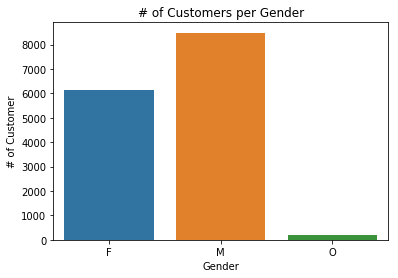

In [282]:
g = sns.barplot(x="gender"
                , y="customer_id"
                , data = profile.groupby("gender")["customer_id"].size().reset_index())

g.set_xlabel("Gender")
g.set_ylabel("# of Customer")
g.set_title("# of Customers per Gender")

In [122]:
customer_spending_per_gender = cus_trans_df.groupby("gender")["amount"].mean().reset_index()

Text(0,0.5,'Average Amount')

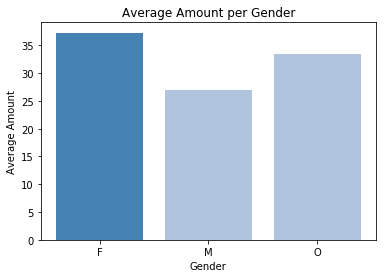

In [123]:
plt.bar(customer_spending_per_gender["gender"], customer_spending_per_gender["amount"],\
        color=('steelblue', 'lightsteelblue', 'lightsteelblue'))
plt.xticks(customer_spending_per_gender["gender"])

# Add title and axis names
plt.title('Average Amount per Gender')
plt.xlabel('Gender')
plt.ylabel('Average Amount')

In [124]:
cus_trans_df["w_offer"] = (cus_trans_df["offer_name"] != "None")

In [125]:
customer_spending_per_gender_offer = cus_trans_df.groupby(["gender", "w_offer"])["amount"].mean().reset_index()

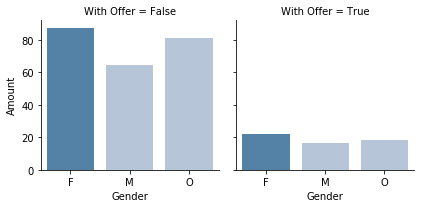

In [270]:
g = sns.FacetGrid(data = customer_spending_per_gender_offer\
                 , col = "w_offer")
clrs=['steelblue', 'lightsteelblue', 'lightsteelblue']
g.map_dataframe(sns.barplot, "gender", "amount", palette=clrs)
g.set_axis_labels("Gender", "Amount")

g.set_titles(col_template = "With Offer = {col_name}")
# g.axes[0,0].set_xlabel("Gender")
# g.axes[0,0].set_ylabel("Amount")

# g.axes[0,1].set_xlabel("Gender")
# g.axes[0,1].set_ylabel("Amount")

# g.axes[0, 0].set_title["Average Amount per Gender without Offers"]
# g.axes[0, 1].set_title["Average Amount per Gender with Offers"]
# plt.title("Average Amount per Gender with Offers")

In [127]:
F_cus_trans_s = cus_trans_df.loc[cus_trans_df["gender"] == "F","amount"]
M_cus_trans_s = cus_trans_df.loc[cus_trans_df["gender"] == "M","amount"]
O_cus_trans_s = cus_trans_df.loc[cus_trans_df["gender"] == "O","amount"]

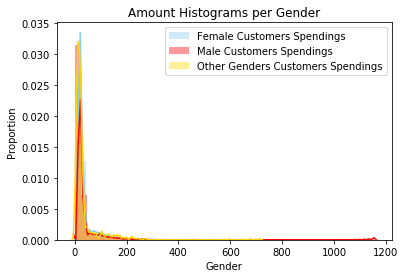

In [128]:
sns.distplot(F_cus_trans_s, color="skyblue", label="Female Customers Spendings")
sns.distplot(M_cus_trans_s, color="red", label="Male Customers Spendings")
sns.distplot(O_cus_trans_s, color="gold", label="Other Genders Customers Spendings")
# plt.xscale("log")
# , yscale="log")

# Add title and axis names
plt.title('Amount Histograms per Gender')
plt.xlabel('Gender')
plt.ylabel('Proportion')
plt.legend()

In [258]:
age_labels = ["18-28", "28-38", "38-48", "48-58", "58-68", "68-78","78-88", "88-98", "98-108", "108 and above"]

In [259]:
cus_trans_df['age_group'] = pd.cut(cus_trans_df["age"], 10, right=False, labels=age_labels)

In [260]:
cus_trans_df['age_group'].unique()

['28-38', '38-48', '58-68', '18-28', '48-58', '108 and above', '68-78', '88-98', '78-88', '98-108']
Categories (10, object): ['18-28' < '28-38' < '38-48' < '48-58' ... '78-88' < '88-98' < '98-108' < '108 and above']

In [253]:
cus_trans_df.loc[(cus_trans_df["age"]>90) & (cus_trans_df["age"] <=98), "age_group"]

116      90-98
117      90-98
118      90-98
119      90-98
1150     90-98
         ...  
62970    82-90
63074    82-90
63174    82-90
63250    82-90
63374    82-90
Name: age_group, Length: 741, dtype: category
Categories (12, object): ['18-26' < '26-34' < '34-42' < '42-50' ... '82-90' < '90-98' < '98-106' < '106 and above']

In [261]:
customer_spending_per_age = cus_trans_df.groupby("age_group")["amount"].mean().reset_index()

In [262]:
customer_spending_per_age

,age_group,amount
0,18-28,21.453416
1,28-38,24.407831
2,38-48,28.958419
3,48-58,33.781156
4,58-68,34.347323
5,68-78,34.180799
6,78-88,35.796983
7,88-98,35.773328
8,98-108,41.082475
9,108 and above,6.355333


Text(0.5,0.98,'Average Spending per Age')

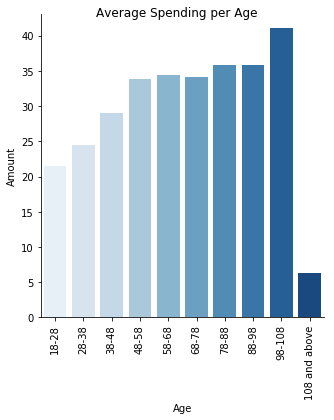

In [275]:
g = sns.catplot(data = customer_spending_per_age
           , x = "age_group"
            , y = "amount"
            , kind = "bar"
            , palette="Blues"
           )

(g.set_axis_labels("Age", "Amount")
 .set_xticklabels(labels = customer_spending_per_age["age_group"], rotation=90)
#  .set_title("Average Spending per Age")
 .fig.suptitle("Average Spending per Age")
)


In [272]:
customer_spending_per_age_offer = cus_trans_df.groupby(["w_offer", "age_group"])["amount"].mean().reset_index()

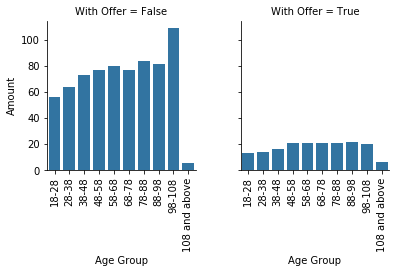

In [276]:
g = sns.FacetGrid(data = customer_spending_per_age_offer\
                 , col = "w_offer")
# clrs=['steelblue', 'lightsteelblue', 'lightsteelblue']
(g.map_dataframe(sns.barplot, "age_group", "amount")
.set_axis_labels("Age Group", "Amount")
.set_titles(col_template = "With Offer = {col_name}")
.set_xticklabels(labels = customer_spending_per_age["age_group"], rotation=90))
 

In [135]:
cus_trans_df["income"].describe()

count     63417.000000
mean      65029.771197
std       20314.520966
min       30000.000000
25%       51000.000000
50%       64000.000000
75%       76000.000000
max      120000.000000
Name: income, dtype: float64

In [136]:
income_labels = ["20000-50000", "50000-80000", "80000-110000", "110000-140000"]

In [137]:
cus_trans_df["income_group"] = pd.cut(cus_trans_df["income"],\
                                      range(20000, 150000, 30000), right=False, labels=income_labels)

In [138]:
cus_trans_df["income_group"] = pd.Categorical(cus_trans_df["income_group"], ordered=True,
                   categories=income_labels)

In [139]:
cus_trans_df["income_group"].unique()

['50000-80000', '80000-110000', '20000-50000', '110000-140000']
Categories (4, object): ['20000-50000' < '50000-80000' < '80000-110000' < '110000-140000']

In [140]:
customer_spending_per_income = cus_trans_df.groupby("income_group")["amount"].mean()

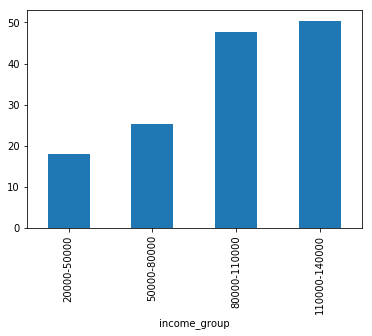

In [141]:
customer_spending_per_income.plot.bar()

# Find Target Customers

To find the target customers. We need to answer these questions:
1. If the customer influenced by the offers
2. If the customer wants to buy with offer. What offer type they preferrred?

## Q1: If the customer influenced by the offers

# Need to clean the data

### Generate the dataset of Q1

In [142]:
trans_cus_q1_received_temp_df = transcript.loc[transcript["event"] =="offer received",\
                                               ["portfolio_id", "customer_id", "event"]]

In [143]:
trans_cus_q1_completed_temp_df = transcript.loc[transcript["event"] =="offer completed",\
                                                ["portfolio_id", "customer_id", "event"]]

In [144]:
trans_cus_q1_received_df = trans_cus_q1_received_temp_df.groupby(["portfolio_id", "customer_id"])\
["event"].count().reset_index()

In [145]:
trans_cus_q1_completed_df = trans_cus_q1_completed_temp_df.groupby(["portfolio_id", "customer_id"])\
["event"].count().reset_index()

In [146]:
trans_cus_q1_received_df = rename_columns(trans_cus_q1_received_df, "event", "offer_received")
trans_cus_q1_completed_df = rename_columns(trans_cus_q1_completed_df, "event", "offer_completed")

In [147]:
trans_cus_q1_temp_df = trans_cus_q1_received_df.merge(trans_cus_q1_completed_df,\
                                                   on=["customer_id", "portfolio_id"],\
                                                   how="left")

In [148]:
trans_cus_q1_temp_df["offer_completed"] = trans_cus_q1_temp_df["offer_completed"].fillna(0)

In [149]:
trans_cus_q1_temp_df["completed_rate"] = trans_cus_q1_temp_df["offer_completed"]/trans_cus_q1_temp_df["offer_received"]

In [150]:
trans_cus_q1_df = trans_final_df.merge(trans_cus_q1_temp_df[["customer_id", "portfolio_id","completed_rate"]],\
                                                               on = ["customer_id", "portfolio_id"],\
                                                               how="left")

In [151]:
trans_cus_q1_df["completed_rate"] = trans_cus_q1_df["completed_rate"].fillna(0) 

In [152]:
trans_cus_q1_df["w_offer"] = trans_cus_q1_df["offer_name"] != "None"

In [153]:
trans_cus_q1_final_df = trans_cus_q1_df[["customer_id", "w_offer", "amount", "completed_rate"]]

In [154]:
trans_cus_q1_final_df = trans_cus_q1_final_df.groupby(["customer_id", "w_offer"]).agg({"amount":sum, "completed_rate": np.mean}).reset_index()

In [155]:
trans_cus_q1_final_df.head()

,customer_id,w_offer,amount,completed_rate
0,0009655768c64bdeb2e877511632db8f,False,94.65,0.0
1,0009655768c64bdeb2e877511632db8f,True,32.95,1.0
2,00116118485d4dfda04fdbaba9a87b5c,False,4.09,0.0
3,0011e0d4e6b944f998e987f904e8c1e5,False,23.43,0.0
4,0011e0d4e6b944f998e987f904e8c1e5,True,56.03,1.0


### Q1: Predict a customer buys with or without offers

Check count of the target variables and if they are balanced

[Text(0,0.5,'Counts'), Text(0.5,0,'With Offers')]

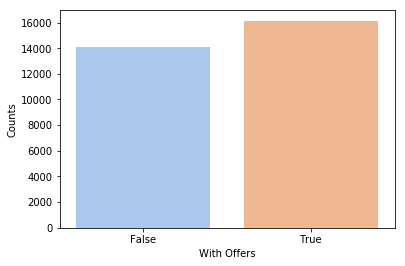

In [156]:
g = sns.countplot(x="w_offer", data=trans_cus_q1_final_df, palette="pastel")
g.set(xlabel="With Offers",
ylabel="Counts")

The targets are balanced.

Check the correlations between independent variables.

In [157]:
trans_cus_q1_final_df[["amount", "completed_rate"]].corr()

,amount,completed_rate
amount,1.000000,0.084642
completed_rate,0.084642,1.000000


Independents variables are not correlated with each other.

check outliers in the dataset

[Text(0,0.5,'Total Spending ($)'), Text(0.5,0,'With Offers')]

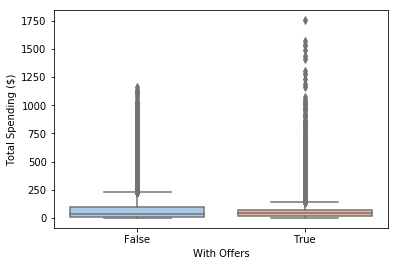

In [158]:
g = sns.boxplot(
x = "w_offer"
, y = "amount"
, data = trans_cus_q1_final_df
,  palette="pastel"    
)
g.set(xlabel="With Offers", ylabel="Total Spending ($)")

There are many amount outliers for the two attributes of the target variables. The outliers will misleading the logistic regression model. Need to convert these outliers or use a model that less sensitive to the outliers like the tree models.

In [159]:
X_q1 = trans_cus_q1_final_df[["amount", "completed_rate"]]
y_q1 = trans_cus_q1_final_df["w_offer"]

In [160]:
SEED=123

In [161]:
X_q1_train, X_q1_test, y_q1_train, y_q1_test = \
train_test_split(X_q1, y_q1, test_size=0.3, random_state=SEED)

In [162]:
def print_metrics(actual, preds, name):
    
    acc_score = round(accuracy_score(actual, preds), 2)
    precision = round(precision_score(actual, preds), 2)
    recall = round(recall_score(actual, preds), 2)
    f1 = round(f1_score(actual, preds), 2)
    
    print(("Accuracy score for {0}: {1}").format(name, str(acc_score)))
    print(("Precision score for {0}: {1}").format(name, str(precision)))
    print(("Recall score for {0}: {1}").format(name, str(recall)))
    print(("F1 score for {0}: {1}").format(name, str(f1)))   

### Logistic Regression Model

In [163]:
scaler = StandardScaler()
q1_logreg = LogisticRegression()
pipeline = make_pipeline(scaler, q1_logreg)
pipeline.fit(X_q1_train, y_q1_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [164]:
logreg = pipeline.named_steps['logisticregression']

In [165]:
logreg.coef_, logreg.intercept_

(array([[-2.26648264, 15.53756771]]), array([9.94284685]))

In [166]:
#get the accuracy of the training set
pipeline.score(X_q1_train, y_q1_train)

0.8895560493593684

In [167]:
#get the accuracy of the testing set
pipeline.score(X_q1_test, y_q1_test)

0.8853959849988969

In [168]:
#get the probability
q1_predictions = pipeline.predict_proba(X_q1)

In [169]:
q1_lg_preds = pipeline.predict(X_q1_test)

In [170]:
print_metrics(y_q1_test, q1_lg_preds, "Logistic Regression")

Accuracy score for Logistic Regression: 0.89
Precision score for Logistic Regression: 1.0
Recall score for Logistic Regression: 0.79
F1 score for Logistic Regression: 0.88


In [171]:
q1_predictions_df = pd.DataFrame(q1_predictions[:, 1], columns=["prob"])

In [172]:
trans_cus_q1_res_df = pd.concat([trans_cus_q1_final_df, q1_predictions_df], axis = 1)

In [173]:
#get the average probability of the customer will buy with an offer
trans_cus_q1_res_df["prob"].mean()

0.5324248323922902

In [174]:
len(trans_cus_q1_res_df.loc[trans_cus_q1_res_df["prob"]>0.5, "customer_id"].unique())\
/len(trans_cus_q1_res_df["customer_id"].unique())

0.7508823529411764

About 75% customers will have more than 50% chance to buy when they have an offer.

The model shows the customers who spent more money in starbucks have less interests on the offers.

In [175]:
trans_cus_q1_res_df.loc[trans_cus_q1_res_df["completed_rate"]>0, "prob"].mean()

0.9984933885034419

For these customer who completed an offer at least once have much higher probability to buy with an offer compare to the change of all customers.

In [176]:
cus_buy_w_offer_df = trans_cus_q1_res_df.loc[trans_cus_q1_res_df["prob"]>0.5, :]

In [177]:
cus_buy_w_offer_demo_df = cus_buy_w_offer_df.merge(profile, on="customer_id")[["customer_id", "gender", "age",\
                                                     "income", "days_since_member", "w_offer", \
                                                     "amount", "completed_rate", "prob"]]

In [178]:
cus_buy_w_offer_demo_df.groupby("gender").agg({"customer_id":pd.Series.nunique,\
                                               "amount":np.mean, "completed_rate":np.mean, "prob":np.mean})

,customer_id,amount,completed_rate,prob
gender,,,,
F,5387,70.280147,0.892737,0.999785
M,6411,60.209626,0.781841,0.998964
O,179,60.801229,0.879407,0.999731


In [179]:
cus_buy_w_offer_per_gender = cus_buy_w_offer_demo_df.groupby("gender").agg({"customer_id":pd.Series.nunique})

In [180]:
cus_count_per_gender = profile.groupby("gender").agg({"customer_id":pd.Series.nunique})

In [181]:
round((cus_buy_w_offer_per_gender/cus_count_per_gender) * 100, 2)

,customer_id
gender,
F,87.89
M,75.57
O,84.43


Although, the probability of buy with an offer are high across all genders. Less male customers buy with the offers compare with other two gender groups.

In [182]:
cus_buy_w_offer_demo_df["days_since_member"].mean(), profile["days_since_member"].mean()

(1456.8591461026244, 1401.4498823529411)

In [183]:
cus_buy_w_offer_demo_df["days_since_member"].describe()

count    12765.000000
mean      1456.859146
std        411.839997
min        884.000000
25%       1130.000000
50%       1360.000000
75%       1731.000000
max       2707.000000
Name: days_since_member, dtype: float64

In [184]:
profile["days_since_member"].describe()

count    17000.000000
mean      1401.449882
std        411.223904
min        884.000000
25%       1092.000000
50%       1242.000000
75%       1675.000000
max       2707.000000
Name: days_since_member, dtype: float64

Customers who buy with offers have lightly longer membership days than overall customers.

### Decision Tree Model

In [185]:
q1_clf_dt = DecisionTreeClassifier(random_state=SEED)

q1_dt_param_dist = {"max_depth" :[4, 8, 10]
                   ,"max_features": list(range(1, X_q1_test.shape[1]+1))
                    , "min_samples_split": list(range(10, 80))
                    , "min_samples_leaf": list(range(10, 30)),
                   }

q1_dt_random_search = RandomizedSearchCV(q1_clf_dt, param_distributions=q1_dt_param_dist)

q1_dt_random_search.fit(X_q1_train, y_q1_train)

q1_dt_model = q1_dt_random_search.best_estimator_

q1_dt_preds = q1_dt_model.predict(X_q1_test)

print_metrics(y_q1_test, q1_dt_preds, "Decision Tree")

q1_dt_model

Accuracy score for Decision Tree: 0.89
Precision score for Decision Tree: 1.0
Recall score for Decision Tree: 0.79
F1 score for Decision Tree: 0.88


DecisionTreeClassifier(max_depth=4, max_features=2, min_samples_leaf=27,
                       min_samples_split=39, random_state=123)

## Q2: If the customer wants to buy with offer. What offer type they preferrred?

Get the customers who have more then 50% probabilities to spend with offers or the customers who have completition rates greater than 0.

### Generate the dataset of Q2

In [186]:
trans_cus_q1_df.head()

,customer_id,portfolio_id,offer_name,amount,completed_rate,w_offer
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,offer_9,10.27,1.0,True
1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,offer_8,8.57,1.0,True
2,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,offer_6,14.11,1.0,True
3,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_4,22.05,1.0,True
4,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,offer_5,11.93,1.0,True


In [187]:
X_q2 = trans_cus_q1_df[["amount", "completed_rate"]]

In [188]:
q2_prediction = pipeline.predict_proba(X_q2)

In [189]:
q2_predictions_df = pd.DataFrame(q2_prediction[:, 1], columns=["prob"])

In [190]:
trans_q2_df = pd.concat([trans_cus_q1_df, q2_predictions_df], axis = 1)

In [191]:
#get the customers who have more than 50% chance to buy with an offer
trans_q2_final_temp_df = trans_q2_df[trans_q2_df["prob"]>0.5]

In [192]:
trans_q2_final_temp_df = trans_q2_final_temp_df.merge(profile, on="customer_id").\
merge(portfolio, on=["portfolio_id", "offer_name"])

In [193]:
trans_q2_final_temp_df.columns

Index(['customer_id', 'portfolio_id', 'offer_name', 'amount', 'completed_rate',
       'w_offer', 'prob', 'gender', 'age', 'became_member_on', 'income',
       'customer_name', 'days_since_member', 'reward', 'difficulty',
       'duration', 'offer_type', 'channel_web', 'channel_email',
       'channel_mobile', 'channel_social'],
      dtype='object')

In [194]:
q2_cols= ["customer_id", "portfolio_id", "gender", "age", "income", "days_since_member",\
          "reward", "difficulty", "duration", "offer_type", "channel_web", "channel_email", \
         "channel_mobile", "channel_social", "amount", "completed_rate", "w_offer", "prob"]

In [195]:
trans_q2_final_temp_df = trans_q2_final_temp_df[q2_cols]

In [196]:
trans_q2_final_temp_df.head()

,customer_id,portfolio_id,gender,age,income,days_since_member,reward,difficulty,duration,offer_type,channel_web,channel_email,channel_mobile,channel_social,amount,completed_rate,w_offer,prob
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,M,33,72000.0,1345,2,10,7,discount,1,1,1,0,10.27,1.0,True,1.0
1,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,None,118,64000.0,1698,2,10,7,discount,1,1,1,0,13.09,0.5,True,1.0
2,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,F,58,119000.0,1115,2,10,7,discount,1,1,1,0,21.35,1.0,True,1.0
3,00840a2ca5d2408e982d56544dc14ffd,2906b810c7d4411798c6938adc9daaa5,M,26,61000.0,2197,2,10,7,discount,1,1,1,0,13.25,0.5,True,1.0
4,00bbce6533f44ddeaf4dd32bcab55441,2906b810c7d4411798c6938adc9daaa5,M,94,50000.0,2220,2,10,7,discount,1,1,1,0,18.51,1.0,True,1.0


In [197]:
trans_q2_gender_df = pd.get_dummies(trans_q2_final_temp_df[["gender"]])

In [198]:
trans_q2_final_temp_df = pd.concat([trans_q2_final_temp_df, trans_q2_gender_df], axis = 1)

In [199]:
trans_q2_offer_df = pd.get_dummies(trans_q2_final_temp_df[["offer_type"]], drop_first=True)

In [200]:
trans_q2_final_temp_df = pd.concat([trans_q2_final_temp_df, trans_q2_offer_df], axis = 1)

In [201]:
drop_category_cols = ["gender", "offer_type"]

In [202]:
trans_q2_final_df = trans_q2_final_temp_df.drop(columns=drop_category_cols)

### Training and Tuning

In [203]:
# input_cols = ["age", "income", "days_since_member",\
#              "channel_web", "channel_email","channel_mobile", "channel_social",\
#               "completed_rate", "prob", "amount", "gender_F", "gender_M", "gender_O"]

In [204]:
input_cols = ["age", "income", "days_since_member",\
#              "channel_web", "channel_email","channel_mobile", "channel_social",\
              "completed_rate", "prob", "amount", "gender_F", "gender_M", "gender_O"]

In [205]:
X_q2 = trans_q2_final_df[input_cols]
y_q2 = trans_q2_final_df["offer_type_discount"]

In [206]:
X_q2_train, X_q2_test, y_q2_train, y_q2_test = train_test_split(X_q2, y_q2, test_size=0.3, random_state=SEED)

**Decision Tree Model**

In [207]:
q2_clf_dt = DecisionTreeClassifier(random_state=SEED)

q2_dt_param_dist = {"max_depth" :[4, 8, 10]
                   ,"max_features": list(range(1, X_q2_test.shape[1]+1))
                    , "min_samples_split": list(range(10, 80))
                    , "min_samples_leaf": list(range(10, 30)),
                   }

dt_random_search = RandomizedSearchCV(q2_clf_dt, param_distributions=q2_dt_param_dist)

dt_random_search.fit(X_q2_train, y_q2_train)

q2_dt_model = dt_random_search.best_estimator_

q2_dt_preds = q2_dt_model.predict(X_q2_test)

print_metrics(y_q2_test, q2_dt_preds, "Decision Tree")

q2_dt_model

Accuracy score for Decision Tree: 0.56
Precision score for Decision Tree: 0.57
Recall score for Decision Tree: 0.67
F1 score for Decision Tree: 0.62


DecisionTreeClassifier(max_depth=10, max_features=7, min_samples_leaf=13,
                       min_samples_split=32, random_state=123)

In [208]:
#feature importances
dt_importances = pd.Series(data = q2_dt_model.feature_importances_,\
                            index = X_q2.columns)

In [209]:
dt_importances.sort_values(ascending = False)

amount               0.551763
days_since_member    0.170019
income               0.114317
age                  0.105980
completed_rate       0.033806
gender_M             0.020563
gender_F             0.003552
gender_O             0.000000
prob                 0.000000
dtype: float64

**Random Forest Model**

In [210]:
q2_clf_rf = RandomForestClassifier(random_state=SEED)

# Set up the hyperparameter search
q2_rf_param_dist = {"max_depth": [4, 8],
              "n_estimators": list(range(10, 100)),
              "max_features": list(range(1, X_q2_test.shape[1]+1)),
              "min_samples_split": list(range(2, 11)),
              "min_samples_leaf": list(range(1, 11)),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}


# Run a randomized search over the hyperparameters
rf_random_search = RandomizedSearchCV(q2_clf_rf, param_distributions=q2_rf_param_dist)

# Fit the model on the training data
rf_random_search.fit(X_q2_train, y_q2_train)

#get the best model
rf_model = rf_random_search.best_estimator_

# Make predictions on the test data
q2_rf_preds = rf_model.predict(X_q2_test)

print_metrics(y_q2_test, q2_rf_preds, 'Random Forest')
rf_model

Accuracy score for Random Forest: 0.58
Precision score for Random Forest: 0.57
Recall score for Random Forest: 0.8
F1 score for Random Forest: 0.67


RandomForestClassifier(max_depth=8, max_features=5, min_samples_leaf=8,
                       min_samples_split=3, n_estimators=89, random_state=123)

In [211]:
rf_importances = pd.Series(data = rf_model.feature_importances_,\
                            index = X_q2.columns)

In [212]:
rf_importances.sort_values(ascending = False)

amount               0.577664
income               0.141055
days_since_member    0.126352
age                  0.095482
completed_rate       0.034613
gender_F             0.012739
gender_M             0.008732
prob                 0.002602
gender_O             0.000759
dtype: float64

**AdaBoost Model**

In [213]:
q2_clf_ada = AdaBoostClassifier(random_state=SEED)

# Set up the hyperparameter search
q2_ada_param_dist = {"n_estimators": list(range(10, 200)),
              "learning_rate":np.linspace(0.2,1,9)}


# Run a randomized search over the hyperparameters
ada_random_search = RandomizedSearchCV(q2_clf_ada, param_distributions=q2_ada_param_dist)

# Fit the model on the training data
ada_random_search.fit(X_q2_train, y_q2_train)

#Get the best model
ada_model = ada_random_search.best_estimator_

# Make predictions on the test data
q2_ada_preds = ada_model.predict(X_q2_test)

# Return your metrics on test data
print_metrics(y_q2_test, q2_ada_preds, 'adaboost')
ada_model

Accuracy score for adaboost: 0.58
Precision score for adaboost: 0.57
Recall score for adaboost: 0.79
F1 score for adaboost: 0.66


AdaBoostClassifier(learning_rate=0.7, n_estimators=56, random_state=123)

In [214]:
ada_importances = pd.Series(data = ada_model.feature_importances_,\
                            index = X_q2.columns\
                            )

In [215]:
ada_importances.sort_values(ascending = False)

amount               0.625000
income               0.125000
days_since_member    0.089286
age                  0.089286
completed_rate       0.053571
gender_F             0.017857
gender_O             0.000000
gender_M             0.000000
prob                 0.000000
dtype: float64

# Need to clean the data

# Playground

## RMF Analysis

In [216]:
rmf_m_prep_df = trans_final_df.loc[:,["customer_id", "offer_name", "amount"]]

In [217]:
rmf_m_prep_df["w_offer"] = (rmf_m_prep_df["offer_name"] == "None").astype(int)

In [218]:
# rmf_m_prep_df.drop(columns = ["offer_name"], inplace = True)

In [219]:
rmf_m_df = rmf_m_prep_df.groupby("customer_id").agg({"amount":sum, "w_offer":np.mean}).reset_index()

In [220]:
rmf_m_df.shape

(17000, 3)

In [221]:
rmf_m_df.head()

,customer_id,amount,w_offer
0,0009655768c64bdeb2e877511632db8f,127.60,0.25
1,00116118485d4dfda04fdbaba9a87b5c,4.09,1.00
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,0.25
3,0020c2b971eb4e9188eac86d93036a77,196.86,0.25
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,0.25


In [222]:
rmf_rf_prep_df = transcript.loc[transcript["amount"]>0, ["customer_id", "time"]]

In [223]:
rmf_f_df = rmf_rf_prep_df.groupby("customer_id").agg({"time":pd.Series.nunique}).reset_index()

In [224]:
rmf_f_df = rename_columns(rmf_f_df, "time", "visit_times")

In [225]:
rmf_r_df = rmf_rf_prep_df.groupby("customer_id").agg({ "time":max}).reset_index()

In [226]:
rmf_r_df.shape

(16578, 2)

In [227]:
rmf_r_df = rename_columns(rmf_r_df, "time", "recent_visit_time")

In [228]:
rmf_df = rmf_m_df.merge(rmf_f_df, on="customer_id", how="left").merge(rmf_r_df, on="customer_id", how="left")

In [229]:
rmf_df[["visit_times", "recent_visit_time"]] = rmf_df[["visit_times", "recent_visit_time"]].fillna(0)

In [230]:
rmf_df.head()

,customer_id,amount,w_offer,visit_times,recent_visit_time
0,0009655768c64bdeb2e877511632db8f,127.60,0.25,8.0,696.0
1,00116118485d4dfda04fdbaba9a87b5c,4.09,1.00,3.0,474.0
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,0.25,5.0,654.0
3,0020c2b971eb4e9188eac86d93036a77,196.86,0.25,8.0,708.0
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,0.25,12.0,672.0


In [231]:
quantiles = rmf_df.quantile(q=[0.8])
print(quantiles)

      amount   w_offer  visit_times  recent_visit_time
0.8  169.642  0.333333         12.0              696.0


In [232]:
rmf_df["R"] = np.where(rmf_df["recent_visit_time"]<=int(quantiles["recent_visit_time"].values), 0, 1)
rmf_df["F"] = np.where(rmf_df["visit_times"]<=int(quantiles["visit_times"].values), 0, 1)
rmf_df["M"] = np.where(rmf_df["amount"]<=int(quantiles["amount"].values), 0, 1)

In [233]:
rmf_df.head()

,customer_id,amount,w_offer,visit_times,recent_visit_time,R,F,M
0,0009655768c64bdeb2e877511632db8f,127.60,0.25,8.0,696.0,0,0,0
1,00116118485d4dfda04fdbaba9a87b5c,4.09,1.00,3.0,474.0,0,0,0
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,0.25,5.0,654.0,0,0,0
3,0020c2b971eb4e9188eac86d93036a77,196.86,0.25,8.0,708.0,1,0,1
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,0.25,12.0,672.0,0,0,0


In [234]:
rmf_df.sort_values(["R", "F", "M"]).head()

,customer_id,amount,w_offer,visit_times,recent_visit_time,R,F,M
0,0009655768c64bdeb2e877511632db8f,127.60,0.25,8.0,696.0,0,0,0
1,00116118485d4dfda04fdbaba9a87b5c,4.09,1.00,3.0,474.0,0,0,0
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,0.25,5.0,654.0,0,0,0
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,0.25,12.0,672.0,0,0,0
9,005500a7188546ff8a767329a2f7c76a,29.39,0.00,4.0,588.0,0,0,0


In [235]:
rmf_matrix = rmf_df.groupby(["R", "F", "M"]).agg({"customer_id":pd.Series.nunique, "w_offer":np.mean}).reset_index()

In [236]:
avg_prob_shopping_w_offer = round(rmf_matrix["w_offer"].mean()*100, 2)

In [237]:
rmf_matrix["% of Customers"] = round((rmf_matrix["customer_id"]/rmf_df.shape[0])*100, 2)

In [238]:
rmf_matrix = rename_columns(rmf_matrix, "customer_id", "# of Customers")
rmf_matrix = rename_columns(rmf_matrix, "w_offer", "Probabilities Shopping with Offers")

In [239]:
rmf_matrix["Probabilities Shopping with Offers"] = round(rmf_matrix["Probabilities Shopping with Offers"] * 100, 2)

In [240]:
rmf_matrix["Probabilities Comparison with Average"] = round(((rmf_matrix["Probabilities Shopping with Offers"]\
                                                              - avg_prob_shopping_w_offer)/avg_prob_shopping_w_offer)*100, 2)

In [241]:
rmf_matrix = rmf_matrix[["R", "F", "M", "# of Customers", "% of Customers",\
"Probabilities Shopping with Offers", "Probabilities Comparison with Average"]].\
sort_values(by = ["M", "F", "R"], ascending = False)

In [242]:
rmf_matrix

,R,F,M,# of Customers,% of Customers,Probabilities Shopping with Offers,Probabilities Comparison with Average
7,1,1,1,326,1.92,21.18,-8.55
3,0,1,1,972,5.72,20.77,-10.32
5,1,0,1,362,2.13,23.54,1.64
1,0,0,1,1763,10.37,23.72,2.42
6,1,1,0,525,3.09,19.90,-14.08
2,0,1,0,1401,8.24,18.69,-19.30
4,1,0,0,1417,8.34,27.05,16.80
0,0,0,0,10234,60.20,30.41,31.30


# Need to clean the data

# Tree based Prediction Model

TODO: Normalized amount

In [243]:
profile.head()

,gender,age,customer_id,became_member_on,income,customer_name,days_since_member
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,customer_0,1413
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,customer_1,1260
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,64000.0,customer_2,898
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,customer_3,1327
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,64000.0,customer_4,1240


In [244]:
offer_trans_port_new_df.head()

NameError: name 'offer_trans_port_new_df' is not defined

In [ ]:
offer_trans_final_temp_df.head()

In [ ]:
# offer_trans_port_final_df = offer_trans_port_new_df.merge(profile, on="customer_id", how="left")\
# [["portfolio_id", "offer_type", "duration", "difficulty", "age", "days_since_member", "gender", "amount"]]

In [ ]:
# offer_trans_port_final_df = offer_trans_port_new_df.merge(profile, on="customer_id", how="left")\
# [["offer_name", "offer_type", "channel_web", "channel_email", "channel_mobile", "channel_social",\
#   "age", "days_since_member", "gender", "amount"]]

In [ ]:
offer_trans_port_final_df = offer_trans_final_temp_df[["offer_name", "offer_type", \
"channel_web", "channel_email", "channel_mobile", "channel_social",\
  "age", "days_since_member", "gender", "amount", "RFMScore"]]

In [ ]:
offer_trans_port_final_df.head()

In [ ]:
offer_trans_port_final_df.info()

In [ ]:
offer_non_trans_port_new_df.head()

In [ ]:
offer_non_trans_port_new_df = offer_non_trans_port_new_df.merge(FRMScore_df, how = "left", on = "customer_id")

In [ ]:
offer_non_trans_port_new_df.info()

In [ ]:
offer_non_trans_port_new_df.drop(columns = ["RFMScore_x"], inplace = True)
# offer_non_trans_port_new_df.rename(columns ={"RFMScore_y":"RFMScore"}, inplace = True)

In [ ]:
offer_non_trans_port_new_df.drop(columns = ["duration", "difficulty"], inplace = True)

In [ ]:
offer_non_trans_port_new_df.head()

In [ ]:
offer_non_trans_port_new_df["offer_type"] = "no"
# offer_non_trans_port_new_df["duration"] = 0
# offer_non_trans_port_new_df["difficulty"] = 0
offer_non_trans_port_new_df["portfolio_id"] = "0"
offer_non_trans_port_new_df["offer_name"] = "None"
offer_non_trans_port_new_df["channel_web"] = 0
offer_non_trans_port_new_df["channel_email"] = 0
offer_non_trans_port_new_df["channel_mobile"] = 0
offer_non_trans_port_new_df["channel_social"] = 0

In [ ]:
offer_non_trans_port_new_df.head()

In [ ]:
# offer_non_trans_port_final_df = offer_non_trans_port_new_df[["portfolio_id", "offer_type", "duration", "difficulty",\
#                                                              "age", "days_since_member", "gender", "amount"]]

In [ ]:
offer_non_trans_port_final_df = offer_non_trans_port_new_df[["offer_name", "offer_type","channel_web", "channel_email", "channel_mobile", "channel_social",\
                                                             "age", "days_since_member", "gender", "amount", "RFMScore"]]

In [ ]:
customer_offer_tree = pd.concat([offer_trans_port_final_df, offer_non_trans_port_final_df])

In [ ]:
customer_offer_tree.head()

In [ ]:
# customer_offer_final_tree = pd.concat([customer_offer_tree, pd.get_dummies(customer_offer_tree[["offer_type", "gender", "duration", "difficulty"]])], axis = 1)

In [ ]:
customer_offer_final_tree = pd.concat([customer_offer_tree, pd.get_dummies(customer_offer_tree[["offer_type", "gender", "RFMScore"]])], axis = 1)

In [ ]:
# customer_offer_final_tree.drop(columns = ["offer_type", "duration", "difficulty", "gender"], inplace = True)

In [ ]:
customer_offer_final_tree.drop(columns = ["offer_type", "gender", "RFMScore"], inplace = True)

In [ ]:
# customer_offer_final_tree.loc[:, ~customer_offer_final_tree.columns.isin(["portfolio_id", "age", "days_since_member", "amount"])] = \
# customer_offer_final_tree.loc[:, ~customer_offer_final_tree.columns.isin(["portfolio_id", "age", "days_since_member", "amount"])].astype('bool')

In [ ]:
customer_offer_final_tree.head()

## Offer Type Classification

In [ ]:
y_clf = customer_offer_final_tree["offer_name"]
X_clf = customer_offer_final_tree.drop(columns = ["offer_name"])

In [ ]:
X_clf.info()

In [ ]:
SEED = 123

In [ ]:
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf, test_size=0.3, random_state=SEED)

In [ ]:
dt_gini = DecisionTreeClassifier(max_depth=6, min_samples_leaf=1000, random_state=SEED)

In [ ]:
dt_gini.fit(X_clf_train, y_clf_train)

In [ ]:
y_gini_pred = dt_gini.predict(X_clf_test)

In [ ]:
accuracy_gini = accuracy_score(y_clf_test, y_gini_pred)
print("Test set accuracy: {:.2f}".format(accuracy_gini))

In [ ]:
FEATURE_NAMES = X_clf_test.columns

In [ ]:
CLASS_NAMES = dt_gini.classes_

In [ ]:
export_graphviz(dt_gini
                , 'gini_tree.dot'
                , feature_names = FEATURE_NAMES
                , class_names = CLASS_NAMES
               )

In [ ]:
! dot -Tpng gini_tree.dot -o gini_tree.png

In [ ]:
img = cv2.imread('gini_tree.png')
plt.figure(figsize = (100, 20))
plt.imshow(img)

In [ ]:
gini_importances = pd.Series(data = dt_gini.feature_importances_,\
                            index = X_clf_train.columns\
                            )

In [ ]:
gini_importances_sorted = gini_importances.sort_values()

In [ ]:
gini_importances_sorted.plot(kind='barh', color="lightgreen")
plt.title("Gini Tree Feature Importances")

In [ ]:
dt_entropy = DecisionTreeClassifier(max_depth=6,  min_samples_leaf=2000, criterion='entropy', random_state=SEED)

In [ ]:
dt_entropy.fit(X_clf_train, y_clf_train)

In [ ]:
y_entropy_pred = dt_entropy.predict(X_clf_test)

In [ ]:
accuracy_entropy = accuracy_score(y_clf_test, y_entropy_pred)
print('Accuracy achieved by using entropy: {:.2f}'.format(accuracy_entropy))

In [ ]:
ENTROPY_CLASS_NAMES = dt_entropy.classes_

In [ ]:
export_graphviz(dt_entropy, 'entropy_tree.dot'
                , feature_names = FEATURE_NAMES
                , class_names = ENTROPY_CLASS_NAMES
                , filled = True
                , rounded = True)

In [ ]:
! dot -Tpng entropy_tree.dot -o entropy_tree.png

In [ ]:
img2 = cv2.imread('entropy_tree.png')
plt.figure(figsize = (20, 20))
plt.imshow(img2)

In [ ]:
entropy_importances = pd.Series(data = dt_entropy.feature_importances_,\
                            index = X_clf_train.columns\
                            )

In [ ]:
entropy_importances_sorted = entropy_importances.sort_values()

In [ ]:
entropy_importances_sorted.plot(kind='barh', color="lightblue")
plt.title("Entropy Tree Feature Importances")

## Random Forest Model

In [ ]:
X_clf_train.shape

In [ ]:
rf_entropy = RandomForestClassifier(n_estimators=25, max_depth=6,\
                                    min_samples_leaf=2000, criterion='entropy', random_state=SEED)

In [ ]:
rf_entropy.fit(X_clf_train, y_clf_train)

In [ ]:
rf_y_entropy_pred = rf_entropy.predict(X_clf_test)

In [ ]:
rf_accuracy_entropy = accuracy_score(y_clf_test, rf_y_entropy_pred)
print('Accuracy achieved by using entropy: {:.2f}'.format(rf_accuracy_entropy))

In [ ]:
rf_entropy_importances = pd.Series(data = rf_entropy.feature_importances_,\
                            index = X_clf_train.columns\
                            )

In [ ]:
rf_entropy_importances_sorted = rf_entropy_importances.sort_values()

In [ ]:
rf_entropy_importances_sorted.plot(kind='barh', color="coral")
plt.title("Entropy RF Feature Importances")

## Interpret Results

In [ ]:
portfolio

In [ ]:
y_entropy_pred

In [ ]:
entropy_pred_df = pd.DataFrame(y_entropy_pred, columns = ["entropy_pred_offer"])

In [ ]:
entropy_pred_df["entropy_pred_offer"].value_counts()

In [ ]:
entropy_pred_df["entropy_pred_offer"].value_counts()/entropy_pred_df["entropy_pred_offer"].shape[0]

In [ ]:
customer_offer_tree["offer_type"].value_counts()

In [ ]:
customer_offer_tree["offer_type"].value_counts()/customer_offer_tree["offer_type"].shape[0]

In [ ]:
customer_offer_final_tree.head()

In [ ]:
avg_sales_by_gender_by_offer_name = offer_df.groupby(["offer_name", "gender"])["amount"].mean().reset_index()

In [ ]:
avg_sales_by_gender_by_offer_name.head()

In [ ]:
g = sns.catplot(x="offer_name"
, y="amount"        
, data=avg_sales_by_gender_by_offer_name
, kind="bar"            
, hue="gender"
, palette=palette_colors
)

g.set_axis_labels("Offer Name", "Avg Spending Amount($)")

The most popular offer on average is offer 4. On average, the gender of Other customers showed the most interests in this offer. The offer 4 is a discount type and displayed the offer on the web and email channel for 10 days. This offer had the highest difficulty level. The offer 3 is the least favorite offer. This is a bogo offer, which provided for 7 days and 5 rewards.

# Need to clean the data 